# Solving the Heat Equation with Neural Networks

In [97]:
import sys
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn.functional as F
from torch.autograd.functional import hessian, jacobian
from torchviz import make_dot

plt.rcParams.update({
        "text.usetex": True,
        "font.family": "serif",
})

FIGPATH = "../figs_alt/"
FIGSIZE = (4, 3)

sys.path.insert(0, "../src")
from utils import minibatch, heat_eq_analytic

dtype = torch.float
#device = torch.device("cuda:0")
device = torch.device("cpu")

#torch.autograd.set_detect_anomaly(True)

In [88]:
def g_trial(x, t, N):
    return (1 - t) * torch.sin(np.pi * x) + x * (1 - x) * t * N

#@torch.jit.script
def ode_loss(input_data, output_data):
    loss = 0
    
    for i in range(input_data.size(0)):
        Jx, Jt, Jn = jacobian(g_trial, (input_data[i,0], input_data[i,1], output_data[i]),create_graph=True)
        Hx, Ht, Hn = hessian(g_trial, (input_data[i,0], input_data[i,1], output_data[i]),create_graph=True)
        loss = loss + (Jt - Hx[0]).pow(2)
    
    return loss / input_data.size(0)

def g_trial_np(x, t, N):
    return (1 - t) * np.sin(np.pi * x) + x * (1 - x) * t * N

def plot_pde(model, grid_size=100, fn = "tmp"):
    # Set up plotting data
    x = np.linspace(0,1,grid_size, dtype=np.float)
    t = np.linspace(0,0.3,grid_size, dtype=np.float)
    x, t = np.meshgrid(x, t) 
    x_flat = x.flatten()
    t_flat = t.flatten()
    X = np.concatenate((x_flat.reshape(-1,1), t_flat.reshape(-1, 1)), axis=1)

    # Convert to pytorch tensors
    xp = torch.from_numpy(X)
    xp = xp.to(dtype).to(device)
    
    # Evaluate model
    model.eval()    
    N_pred = model(xp)
    N_pred = N_pred.detach().numpy()
    N_pred = N_pred.reshape(grid_size, grid_size)

    g = g_trial_np(x, t, N_pred)

    fig, ax = plt.subplots(figsize=FIGSIZE)
    #cf = ax.pcolormesh(x, t, g, cmap=plt.get_cmap("inferno"))
    cf = ax.pcolormesh(x, t, g, cmap=plt.get_cmap("jet"))
    fig.colorbar(cf, ax=ax)
    ax.set_xlabel("$x$")
    ax.set_ylabel("$t$")
    
    plt.savefig(FIGPATH + fn + ".pdf")
    
    return
    
def plot_error(model, x, t, fn = "tmp"):
    x, t = np.meshgrid(x, t) 
    x_flat = x.flatten()
    t_flat = t.flatten()
    X = np.concatenate((x_flat.reshape(-1,1), t_flat.reshape(-1, 1)), axis=1)
    
    # Convert to pytorch tensors
    xp = torch.from_numpy(X)
    xp = xp.to(dtype).to(device)
    
    # Evaluate model
    model.eval()    
    N_pred = model(xp)
    N_pred = N_pred.detach().numpy()
    N_pred = N_pred.reshape(x.shape)
    
    g_model = g_trial_np(x, t, N_pred)
    g_analytic = heat_eq_analytic(x, t)
    
    #square_error = (g_model - g_analytic)**2
    #MSE = np.mean(square_error.flatten())
    
    relative_error = np.abs(g_model - g_analytic) 
    MAE = np.mean(relative_error.flatten())
    
    fig, ax = plt.subplots(figsize=FIGSIZE)
    #cf = ax.pcolormesh(x, t, g, cmap=plt.get_cmap("inferno"))
    #cf = ax.pcolormesh(x, t, relative_error, cmap=plt.get_cmap("inferno"),label="MSE")
    cf = ax.pcolormesh(x, t, relative_error, cmap=plt.get_cmap("jet"),label="MSE")
    cmap = fig.colorbar(cf, ax=ax)
    cmap.set_label("Absolute Error")
    t = ax.annotate("MAE = %.2e" % MAE, xy=(0.05 * np.amax(x_flat), 0.05 * np.amax(t_flat)))
    t.set_bbox(dict(facecolor='white', alpha=0.5))
    ax.set_xlabel("$x$")
    ax.set_ylabel("$t$")
    
    plt.savefig(FIGPATH + fn + ".pdf")
    
    return

In [3]:
def generate_trainingdata(x, t):
    x, t = np.meshgrid(x, t) 
    x = x.flatten()
    t = t.flatten()
    X = np.concatenate((x.reshape(-1,1), t.reshape(-1, 1)), axis=1)

    # Convert to pytorch tensors
    x = torch.from_numpy(X)
    x = x.to(dtype).to(device)
    x.requires_grad = True
    return x

# Training on a 11x11 Grid

We first train a model on an equispaced 10x10 grid using a FFNN with 2 hidden layers with 100 neurons each and the ReLU activation function.

In [4]:
# Set up data in numpy
grid_size = 11

x = generate_trainingdata(
    x = np.linspace(0,1,grid_size, dtype=np.float),
    t = np.linspace(0,0.3,grid_size, dtype=np.float)
)

# Shape of the network
num_points, input_dim = x.shape
hidden_neurons = 100
output_dim = 1

# Set up the model
learning_rate = 0.002
N_minibatches = int(num_points / 16)

model_10 = torch.nn.Sequential(
    torch.nn.Linear(input_dim, hidden_neurons),
    torch.nn.ReLU(),
    torch.nn.Linear(hidden_neurons, hidden_neurons),
    torch.nn.ReLU(),
    torch.nn.Linear(hidden_neurons, hidden_neurons),
    torch.nn.ReLU(),
    torch.nn.Linear(hidden_neurons, hidden_neurons),
    torch.nn.ReLU(),
    torch.nn.Linear(hidden_neurons, output_dim),
)
optimizer_10 = torch.optim.Adam(model_10.parameters(), lr=learning_rate)

TOT_EPOCHS_10 = 0

loss_arr_tot_10 = np.empty(0, dtype=np.float)
epoch_arr_tot_10 = np.empty(0, dtype=np.float)

In [72]:
EPOCHS = 3000

loss_arr_curr_10 = np.empty(EPOCHS, dtype=np.float)
epoch_arr_curr_10 = np.empty(EPOCHS, dtype=np.float)

model_10.train()
for epoch in range(EPOCHS):
    # Pick out a new set of minibatches
    mb = minibatch(num_points, N_minibatches)
    for i in range(N_minibatches):
        N_output = model_10(x[mb[i]])           # Forward pass
        loss = ode_loss(x[mb[i]], N_output)  # Compute loss
        optimizer_10.zero_grad()                # Zero gradients from prev itter
        loss.backward()                      # Backward pass
        optimizer_10.step()                     # Optimize with ADAM
        
    # Compute loss of entire sample
    N_output = model_10(x) 
    loss = ode_loss(x, N_output)
    if epoch % 100 == 0:
        print(f"{TOT_EPOCHS_10 + epoch}: loss = ",loss) 
    loss_arr_curr_10[epoch] = loss
    epoch_arr_curr_10[epoch] = TOT_EPOCHS_10 + epoch

TOT_EPOCHS_10 += EPOCHS    
loss_arr_tot_10 = np.append(loss_arr_tot_10, loss_arr_curr_10)
epoch_arr_tot_10 = np.append(epoch_arr_tot_10, epoch_arr_curr_10)

2000: loss =  tensor([0.0001], grad_fn=<DivBackward0>)
2100: loss =  tensor([0.0008], grad_fn=<DivBackward0>)
2200: loss =  tensor([0.0020], grad_fn=<DivBackward0>)
2300: loss =  tensor([0.0003], grad_fn=<DivBackward0>)
2400: loss =  tensor([0.0004], grad_fn=<DivBackward0>)
2500: loss =  tensor([0.0004], grad_fn=<DivBackward0>)
2600: loss =  tensor([0.0003], grad_fn=<DivBackward0>)
2700: loss =  tensor([0.0150], grad_fn=<DivBackward0>)
2800: loss =  tensor([0.0011], grad_fn=<DivBackward0>)
2900: loss =  tensor([0.0016], grad_fn=<DivBackward0>)
3000: loss =  tensor([0.0007], grad_fn=<DivBackward0>)
3100: loss =  tensor([0.0021], grad_fn=<DivBackward0>)
3200: loss =  tensor([0.0004], grad_fn=<DivBackward0>)
3300: loss =  tensor([0.0003], grad_fn=<DivBackward0>)
3400: loss =  tensor([0.0048], grad_fn=<DivBackward0>)
3500: loss =  tensor([0.0001], grad_fn=<DivBackward0>)
3600: loss =  tensor([0.0001], grad_fn=<DivBackward0>)
3700: loss =  tensor([0.0016], grad_fn=<DivBackward0>)
3800: loss

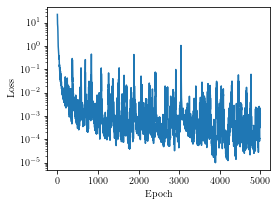

In [98]:
plt.figure(figsize=FIGSIZE)
plt.semilogy(epoch_arr_tot_10, loss_arr_tot_10)
plt.ylabel("Loss")
plt.xlabel("Epoch")
plt.savefig(FIGPATH+"PDE_RELU_LOSS.pdf")

<ipython-input-88-79616b5cb3f7>:41: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  cf = ax.pcolormesh(x, t, g, cmap=plt.get_cmap("jet"))
<ipython-input-88-79616b5cb3f7>:78: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  cf = ax.pcolormesh(x, t, relative_error, cmap=plt.get_cmap("jet"),label="MSE")


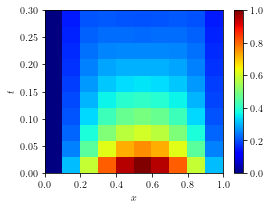

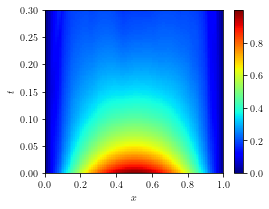

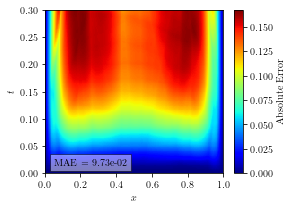

In [99]:
plot_pde(model_10, 11, fn="PDE_RELU_10_10x1000")
plot_pde(model_10, 100, fn="PDE_RELU_10_100x100")
plot_error(model_10, np.linspace(0,1, 200), np.linspace(0,0.3,200), fn="PDE_RELU_10_ERR")

In [7]:
#make_dot(N_output).render("output_graph", format="pdf")
#make_dot(loss).render("loss_graph", format="pdf")

# Training on a 100x100 Grid

In [8]:
# Set up data in numpy
grid_size = 100

x = generate_trainingdata(
    x = np.linspace(0,1,grid_size, dtype=np.float),
    t = np.linspace(0,0.3,grid_size, dtype=np.float)
)

In [9]:
# Shape of the network
num_points, input_dim = x.shape
hidden_neurons = 20
output_dim = 1

# Set up the model
learning_rate = 0.002
N_minibatches = int(num_points / 16)

model_100 = torch.nn.Sequential(
    torch.nn.Linear(input_dim, hidden_neurons),
    torch.nn.ReLU(),
    torch.nn.Linear(hidden_neurons, hidden_neurons),
    torch.nn.ReLU(),
    torch.nn.Linear(hidden_neurons, hidden_neurons),
    torch.nn.ReLU(),
    torch.nn.Linear(hidden_neurons, hidden_neurons),
    torch.nn.ReLU(),
    torch.nn.Linear(hidden_neurons, output_dim),
)
optimizer_100 = torch.optim.Adam(model_100.parameters(), lr=learning_rate)

TOT_EPOCHS_100 = 0

loss_arr_tot_100 = np.empty(0, dtype=np.float)
epoch_arr_tot_100 = np.empty(0, dtype=np.float)

print("Number of minibatches = ", N_minibatches)

Number of minibatches =  625


## Notes

- Gradient changes most rapidly at t ~ 0 to 0.2, so these areas will be most critical for the network to fit correclty. Later, less steeper parts of the function will likely have less of an effect on the cost function

0: loss =  tensor([1.8139], grad_fn=<DivBackward0>)
1: loss =  tensor([0.4249], grad_fn=<DivBackward0>)
2: loss =  tensor([0.1410], grad_fn=<DivBackward0>)
3: loss =  tensor([0.0541], grad_fn=<DivBackward0>)
4: loss =  tensor([0.0348], grad_fn=<DivBackward0>)
5: loss =  tensor([0.0272], grad_fn=<DivBackward0>)
6: loss =  tensor([0.0234], grad_fn=<DivBackward0>)
7: loss =  tensor([0.0161], grad_fn=<DivBackward0>)
8: loss =  tensor([0.0125], grad_fn=<DivBackward0>)
9: loss =  tensor([0.0222], grad_fn=<DivBackward0>)
10: loss =  tensor([0.0097], grad_fn=<DivBackward0>)
11: loss =  tensor([0.0119], grad_fn=<DivBackward0>)
12: loss =  tensor([0.0106], grad_fn=<DivBackward0>)
13: loss =  tensor([0.0085], grad_fn=<DivBackward0>)
14: loss =  tensor([0.0065], grad_fn=<DivBackward0>)
15: loss =  tensor([0.0055], grad_fn=<DivBackward0>)
16: loss =  tensor([0.0067], grad_fn=<DivBackward0>)
17: loss =  tensor([0.0188], grad_fn=<DivBackward0>)
18: loss =  tensor([0.0032], grad_fn=<DivBackward0>)
19:

Text(0.5, 0, 'Epoch')

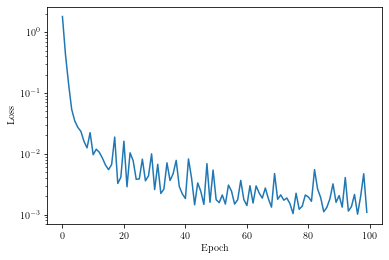

In [10]:
EPOCHS = 100

loss_arr_curr_100 = np.empty(EPOCHS, dtype=np.float)
epoch_arr_curr_100 = np.empty(EPOCHS, dtype=np.float)

model_100.train()
for epoch in range(EPOCHS):
    # Pick out a new set of minibatches
    mb = minibatch(num_points, N_minibatches)
    for i in range(N_minibatches):
        N_output = model_100(x[mb[i]])           # Forward pass
        loss = ode_loss(x[mb[i]], N_output)  # Compute loss
        optimizer_100.zero_grad()                # Zero gradients from prev itter
        loss.backward()                      # Backward pass
        optimizer_100.step()                     # Optimize with ADAM
        
    # Compute loss of entire sample
    N_output = model_100(x) 
    loss = ode_loss(x, N_output)
    print(f"{TOT_EPOCHS_100 + epoch}: loss = ",loss) 
    loss_arr_curr_100[epoch] = loss
    epoch_arr_curr_100[epoch] = TOT_EPOCHS_100 + epoch

TOT_EPOCHS_100 += EPOCHS    
loss_arr_tot_100 = np.append(loss_arr_tot_100, loss_arr_curr_100)
epoch_arr_tot_100 = np.append(epoch_arr_tot_100, epoch_arr_curr_100)

plt.semilogy(epoch_arr_tot_100, loss_arr_tot_100)
plt.ylabel("Loss")
plt.xlabel("Epoch")

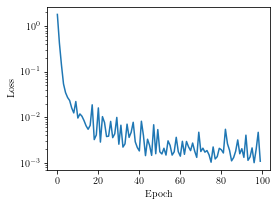

In [100]:
plt.figure(figsize=FIGSIZE)
plt.semilogy(epoch_arr_tot_100, loss_arr_tot_100)
plt.ylabel("Loss")
plt.xlabel("Epoch")
plt.savefig(FIGPATH+"PDE_RELU_LOSS_100.pdf")

<ipython-input-88-79616b5cb3f7>:41: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  cf = ax.pcolormesh(x, t, g, cmap=plt.get_cmap("jet"))
<ipython-input-88-79616b5cb3f7>:78: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  cf = ax.pcolormesh(x, t, relative_error, cmap=plt.get_cmap("jet"),label="MSE")


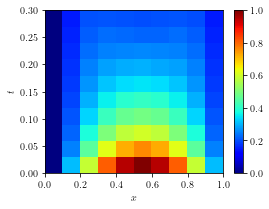

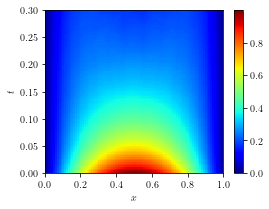

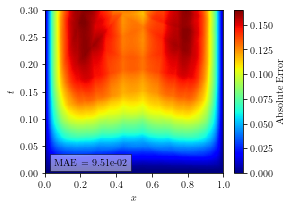

In [101]:
plot_pde(model=model_100, grid_size=11, fn="PDE_RELU_100_10x10")
plot_pde(model=model_100, grid_size=100, fn="PDE_RELU_100_100x100")
plot_error(model_100, np.linspace(0,1, 200), np.linspace(0,0.3,200), fn="PDE_RELU_100_ERR")

## Random sampling

In [12]:
# Set up data in numpy
grid_size = 11

x = generate_trainingdata(
    x = np.random.uniform(0,1,grid_size),
    t = np.random.uniform(0,0.3,grid_size)
)

In [13]:
# Shape of the network
num_points, input_dim = x.shape
hidden_neurons = 100
output_dim = 1

# Set up the model
learning_rate = 0.002
N_minibatches = int(num_points / 16)

model_rand = torch.nn.Sequential(
    torch.nn.Linear(input_dim, hidden_neurons),
    torch.nn.ReLU(),
    torch.nn.Linear(hidden_neurons, hidden_neurons),
    torch.nn.ReLU(),
    torch.nn.Linear(hidden_neurons, hidden_neurons),
    torch.nn.ReLU(),
    torch.nn.Linear(hidden_neurons, hidden_neurons),
    torch.nn.ReLU(),
    torch.nn.Linear(hidden_neurons, output_dim),
)
optimizer_rand = torch.optim.Adam(model_rand.parameters(), lr=learning_rate)

TOT_EPOCHS_rand = 0

loss_arr_tot_rand = np.empty(0, dtype=np.float)
epoch_arr_tot_rand = np.empty(0, dtype=np.float)

print("Number of minibatches = ", N_minibatches)

Number of minibatches =  7


2000: loss =  tensor([0.0856], grad_fn=<DivBackward0>)
2100: loss =  tensor([0.0051], grad_fn=<DivBackward0>)
2200: loss =  tensor([0.0009], grad_fn=<DivBackward0>)
2300: loss =  tensor([0.0019], grad_fn=<DivBackward0>)
2400: loss =  tensor([0.0013], grad_fn=<DivBackward0>)
2500: loss =  tensor([0.0022], grad_fn=<DivBackward0>)
2600: loss =  tensor([0.0013], grad_fn=<DivBackward0>)
2700: loss =  tensor([0.0008], grad_fn=<DivBackward0>)
2800: loss =  tensor([0.0017], grad_fn=<DivBackward0>)
2900: loss =  tensor([0.0095], grad_fn=<DivBackward0>)
3000: loss =  tensor([0.0017], grad_fn=<DivBackward0>)
3100: loss =  tensor([0.0012], grad_fn=<DivBackward0>)
3200: loss =  tensor([0.0015], grad_fn=<DivBackward0>)
3300: loss =  tensor([0.0042], grad_fn=<DivBackward0>)
3400: loss =  tensor([0.0004], grad_fn=<DivBackward0>)
3500: loss =  tensor([0.0013], grad_fn=<DivBackward0>)
3600: loss =  tensor([0.0006], grad_fn=<DivBackward0>)
3700: loss =  tensor([0.0001], grad_fn=<DivBackward0>)
3800: loss

Text(0.5, 0, 'Epoch')

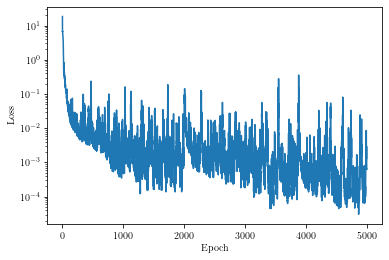

In [73]:
EPOCHS = 3000

loss_arr_curr_rand = np.empty(EPOCHS, dtype=np.float)
epoch_arr_curr_rand = np.empty(EPOCHS, dtype=np.float)

model_rand.train()
for epoch in range(EPOCHS):
    # Pick out a new set of minibatches
    mb = minibatch(num_points, N_minibatches)
    for i in range(N_minibatches):
        N_output = model_rand(x[mb[i]])      # Forward pass
        loss = ode_loss(x[mb[i]], N_output)  # Compute loss
        optimizer_rand.zero_grad()           # Zero gradients from prev itter
        loss.backward()                      # Backward pass
        optimizer_rand.step()                # Optimize with ADAM
        
    # Compute loss of entire sample
    N_output = model_rand(x) 
    loss = ode_loss(x, N_output)
    if epoch % 100 == 0:
        print(f"{TOT_EPOCHS_rand + epoch}: loss = ",loss) 
    loss_arr_curr_rand[epoch] = loss
    epoch_arr_curr_rand[epoch] = TOT_EPOCHS_rand + epoch

TOT_EPOCHS_rand += EPOCHS    
loss_arr_tot_rand = np.append(loss_arr_tot_rand, loss_arr_curr_rand)
epoch_arr_tot_rand = np.append(epoch_arr_tot_rand, epoch_arr_curr_rand)

plt.semilogy(epoch_arr_tot_rand, loss_arr_tot_rand)
plt.ylabel("Loss")
plt.xlabel("Epoch")

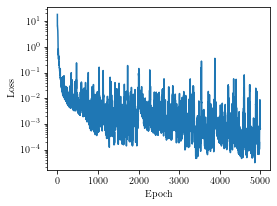

In [102]:
plt.figure(figsize=FIGSIZE)
plt.semilogy(epoch_arr_tot_rand, loss_arr_tot_rand)
plt.ylabel("Loss")
plt.xlabel("Epoch")
plt.savefig(FIGPATH+"PDE_RELU_LOSS_RAND.pdf")

<ipython-input-88-79616b5cb3f7>:41: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  cf = ax.pcolormesh(x, t, g, cmap=plt.get_cmap("jet"))
<ipython-input-88-79616b5cb3f7>:78: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  cf = ax.pcolormesh(x, t, relative_error, cmap=plt.get_cmap("jet"),label="MSE")


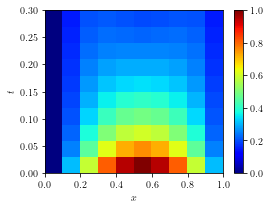

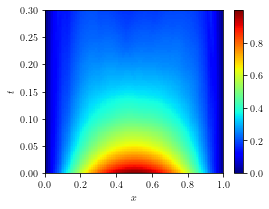

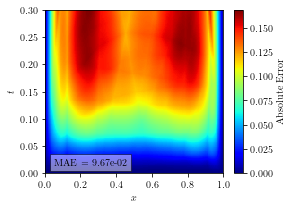

In [103]:
plot_pde(model=model_rand, grid_size=11, fn="PDE_RELU_RAND_10x10")
plot_pde(model=model_rand, grid_size=100, fn="PDE_RELU_RAND_100x100")
plot_error(model_rand, np.linspace(0,1, 200), np.linspace(0,0.3,200),fn="PDE_RELU_RAND_ERR")

# Testing different activations
## Sigmoid

In [16]:
activation_function = torch.nn.Sigmoid()

# Set up data in numpy
grid_size = 11

x = generate_trainingdata(
    x = np.linspace(0,1,grid_size, dtype=np.float),
    t = np.linspace(0,0.3,grid_size, dtype=np.float)
)

# Shape of the network
num_points, input_dim = x.shape
hidden_neurons = 100
output_dim = 1

# Set up the model
learning_rate = 0.002
N_minibatches = int(num_points / 16)

model_sigmoid = torch.nn.Sequential(
    torch.nn.Linear(input_dim, hidden_neurons),
    activation_function,
    torch.nn.Linear(hidden_neurons, hidden_neurons),
    activation_function,
    torch.nn.Linear(hidden_neurons, hidden_neurons),
    activation_function,
    torch.nn.Linear(hidden_neurons, hidden_neurons),
    activation_function,
    torch.nn.Linear(hidden_neurons, output_dim),
)
optimizer_sigmoid = torch.optim.Adam(model_sigmoid.parameters(), lr=learning_rate)

TOT_EPOCHS_sigmoid = 0

loss_arr_tot_sigmoid = np.empty(0, dtype=np.float)
epoch_arr_tot_sigmoid = np.empty(0, dtype=np.float)

2000: loss =  tensor([0.0034], grad_fn=<DivBackward0>)
2100: loss =  tensor([0.0022], grad_fn=<DivBackward0>)
2200: loss =  tensor([0.0019], grad_fn=<DivBackward0>)
2300: loss =  tensor([0.0039], grad_fn=<DivBackward0>)
2400: loss =  tensor([0.0039], grad_fn=<DivBackward0>)
2500: loss =  tensor([0.0016], grad_fn=<DivBackward0>)
2600: loss =  tensor([0.0013], grad_fn=<DivBackward0>)
2700: loss =  tensor([0.0010], grad_fn=<DivBackward0>)
2800: loss =  tensor([0.0025], grad_fn=<DivBackward0>)
2900: loss =  tensor([0.0008], grad_fn=<DivBackward0>)
3000: loss =  tensor([0.0018], grad_fn=<DivBackward0>)
3100: loss =  tensor([0.0489], grad_fn=<DivBackward0>)
3200: loss =  tensor([0.0011], grad_fn=<DivBackward0>)
3300: loss =  tensor([0.0013], grad_fn=<DivBackward0>)
3400: loss =  tensor([0.0043], grad_fn=<DivBackward0>)
3500: loss =  tensor([0.0015], grad_fn=<DivBackward0>)
3600: loss =  tensor([0.0013], grad_fn=<DivBackward0>)
3700: loss =  tensor([0.0003], grad_fn=<DivBackward0>)
3800: loss

Text(0.5, 0, 'Epoch')

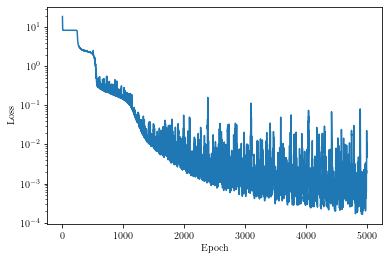

In [74]:
EPOCHS = 3000

loss_arr_curr_sigmoid = np.empty(EPOCHS, dtype=np.float)
epoch_arr_curr_sigmoid = np.empty(EPOCHS, dtype=np.float)

model_sigmoid.train()
for epoch in range(EPOCHS):
    # Pick out a new set of minibatches
    mb = minibatch(num_points, N_minibatches)
    for i in range(N_minibatches):
        N_output = model_sigmoid(x[mb[i]])           # Forward pass
        loss = ode_loss(x[mb[i]], N_output)  # Compute loss
        optimizer_sigmoid.zero_grad()                # Zero gradients from prev itter
        loss.backward()                      # Backward pass
        optimizer_sigmoid.step()                     # Optimize with ADAM
        
    # Compute loss of entire sample
    N_output = model_sigmoid(x) 
    loss = ode_loss(x, N_output)
    if epoch % 100 == 0:
        print(f"{TOT_EPOCHS_sigmoid + epoch}: loss = ",loss) 
    loss_arr_curr_sigmoid[epoch] = loss
    epoch_arr_curr_sigmoid[epoch] = TOT_EPOCHS_sigmoid + epoch

TOT_EPOCHS_sigmoid += EPOCHS    
loss_arr_tot_sigmoid = np.append(loss_arr_tot_sigmoid, loss_arr_curr_sigmoid)
epoch_arr_tot_sigmoid = np.append(epoch_arr_tot_sigmoid, epoch_arr_curr_sigmoid)

plt.semilogy(epoch_arr_tot_sigmoid, loss_arr_tot_sigmoid)
plt.ylabel("Loss")
plt.xlabel("Epoch")

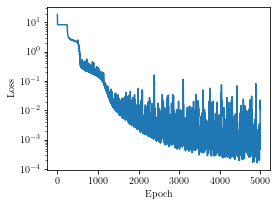

In [104]:
plt.figure(figsize=FIGSIZE)
plt.semilogy(epoch_arr_tot_sigmoid, loss_arr_tot_sigmoid)
plt.ylabel("Loss")
plt.xlabel("Epoch")
plt.savefig(FIGPATH+"PDE_SIG_LOSS.pdf")

<ipython-input-88-79616b5cb3f7>:41: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  cf = ax.pcolormesh(x, t, g, cmap=plt.get_cmap("jet"))
<ipython-input-88-79616b5cb3f7>:78: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  cf = ax.pcolormesh(x, t, relative_error, cmap=plt.get_cmap("jet"),label="MSE")


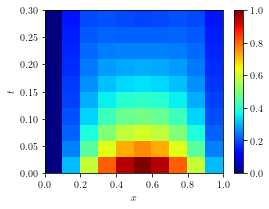

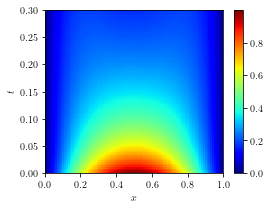

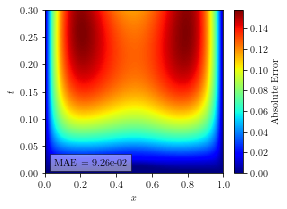

In [105]:
plot_pde(model=model_sigmoid, grid_size=11, fn="PDE_SIG_10x10")
plot_pde(model=model_sigmoid, grid_size=100, fn="PDE_SIG_100x100")
plot_error(model_sigmoid, np.linspace(0,1, 200), np.linspace(0,0.3,200), fn="PDE_SIG_ERR")

## Tanh

In [19]:
activation_function = torch.nn.Tanh()

# Set up data in numpy
grid_size = 11

x = generate_trainingdata(
    x = np.linspace(0,1,grid_size, dtype=np.float),
    t = np.linspace(0,0.3,grid_size, dtype=np.float)
)

# Shape of the network
num_points, input_dim = x.shape
hidden_neurons = 100
output_dim = 1

# Set up the model
learning_rate = 0.002
N_minibatches = int(num_points / 16)

model_tanh = torch.nn.Sequential(
    torch.nn.Linear(input_dim, hidden_neurons),
    activation_function,
    torch.nn.Linear(hidden_neurons, hidden_neurons),
    activation_function,
    torch.nn.Linear(hidden_neurons, hidden_neurons),
    activation_function,
    torch.nn.Linear(hidden_neurons, hidden_neurons),
    activation_function,
    torch.nn.Linear(hidden_neurons, output_dim),
)
optimizer_tanh = torch.optim.Adam(model_tanh.parameters(), lr=learning_rate)

TOT_EPOCHS_tanh = 0

loss_arr_tot_tanh = np.empty(0, dtype=np.float)
epoch_arr_tot_tanh = np.empty(0, dtype=np.float)



2000: loss =  tensor([0.0059], grad_fn=<DivBackward0>)
2100: loss =  tensor([0.0011], grad_fn=<DivBackward0>)
2200: loss =  tensor([0.0322], grad_fn=<DivBackward0>)
2300: loss =  tensor([0.0003], grad_fn=<DivBackward0>)
2400: loss =  tensor([0.0107], grad_fn=<DivBackward0>)
2500: loss =  tensor([0.0168], grad_fn=<DivBackward0>)
2600: loss =  tensor([0.0007], grad_fn=<DivBackward0>)
2700: loss =  tensor([0.0052], grad_fn=<DivBackward0>)
2800: loss =  tensor([0.0005], grad_fn=<DivBackward0>)
2900: loss =  tensor([0.0001], grad_fn=<DivBackward0>)
3000: loss =  tensor([0.0128], grad_fn=<DivBackward0>)
3100: loss =  tensor([0.0270], grad_fn=<DivBackward0>)
3200: loss =  tensor([0.0030], grad_fn=<DivBackward0>)
3300: loss =  tensor([0.0004], grad_fn=<DivBackward0>)
3400: loss =  tensor([0.0002], grad_fn=<DivBackward0>)
3500: loss =  tensor([0.0006], grad_fn=<DivBackward0>)
3600: loss =  tensor([0.0005], grad_fn=<DivBackward0>)
3700: loss =  tensor([0.0018], grad_fn=<DivBackward0>)
3800: loss

Text(0.5, 0, 'Epoch')

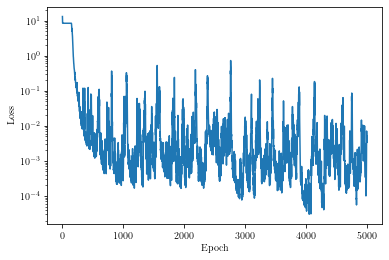

In [75]:
EPOCHS = 3000

loss_arr_curr_tanh = np.empty(EPOCHS, dtype=np.float)
epoch_arr_curr_tanh = np.empty(EPOCHS, dtype=np.float)

model_tanh.train()
for epoch in range(EPOCHS):
    # Pick out a new set of minibatches
    mb = minibatch(num_points, N_minibatches)
    for i in range(N_minibatches):
        N_output = model_tanh(x[mb[i]])           # Forward pass
        loss = ode_loss(x[mb[i]], N_output)  # Compute loss
        optimizer_tanh.zero_grad()                # Zero gradients from prev itter
        loss.backward()                      # Backward pass
        optimizer_tanh.step()                     # Optimize with ADAM
        
    # Compute loss of entire sample
    N_output = model_tanh(x) 
    loss = ode_loss(x, N_output)
    if epoch % 100 == 0:
        print(f"{TOT_EPOCHS_tanh + epoch}: loss = ",loss) 
    loss_arr_curr_tanh[epoch] = loss
    epoch_arr_curr_tanh[epoch] = TOT_EPOCHS_tanh + epoch

TOT_EPOCHS_tanh += EPOCHS    
loss_arr_tot_tanh = np.append(loss_arr_tot_tanh, loss_arr_curr_tanh)
epoch_arr_tot_tanh = np.append(epoch_arr_tot_tanh, epoch_arr_curr_tanh)

plt.semilogy(epoch_arr_tot_tanh, loss_arr_tot_tanh)
plt.ylabel("Loss")
plt.xlabel("Epoch")

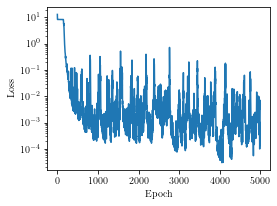

In [106]:
plt.figure(figsize=FIGSIZE)
plt.semilogy(epoch_arr_tot_tanh, loss_arr_tot_tanh)
plt.ylabel("Loss")
plt.xlabel("Epoch")
plt.savefig(FIGPATH+"PDE_TANH_LOSS.pdf")

<ipython-input-88-79616b5cb3f7>:41: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  cf = ax.pcolormesh(x, t, g, cmap=plt.get_cmap("jet"))
<ipython-input-88-79616b5cb3f7>:78: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  cf = ax.pcolormesh(x, t, relative_error, cmap=plt.get_cmap("jet"),label="MSE")


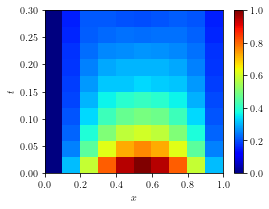

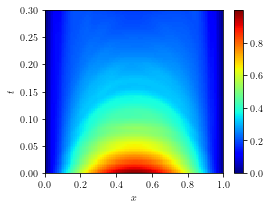

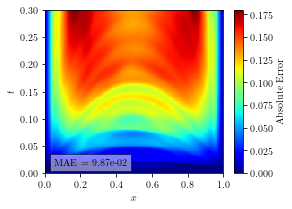

In [107]:
plot_pde(model=model_tanh, grid_size=11, fn="PDE_TANH_10x10")
plot_pde(model=model_tanh, grid_size=100, fn="PDE_TANH_100x100")
plot_error(model_tanh, np.linspace(0,1, 200), np.linspace(0,0.3,200), fn="PDE_TANH_ERR")